<a href="https://colab.research.google.com/github/enelene/Walmart-Recruiting---Store-Sales-Forecasting/blob/main/model_experiment_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import sys
# Add the directory containing your script to the Python path
sys.path.append('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main')


In [3]:
!pip install -r  drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11

In [3]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
import warnings
from joblib import Parallel, delayed
import mlflow
import mlflow.statsmodels
import dagshub

In [5]:

!pip install joblib
from joblib import Parallel, delayed

In [6]:
try:
    dagshub.init(repo_owner='enelene', repo_name='Walmart-Recruiting---Store-Sales-Forecasting', mlflow=True)
    mlflow.set_tracking_uri("https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow")
    os.environ['MLFLOW_TRACKING_USERNAME'] = 'enelene'
    os.environ['MLFLOW_TRACKING_PASSWORD'] = 'cbe8109dbe80931664d754dbd476356414fa62a0'
    EXPERIMENT_NAME = "SARIMAX_Full_Production_Run"
    mlflow.set_experiment(EXPERIMENT_NAME)
    print(f"MLflow experiment set to: '{EXPERIMENT_NAME}'")
except Exception as e:
    print(f"MLflow/Dagshub setup failed: {e}")


Accessing as enelene

Initialized MLflow to track repo "enelene/Walmart-Recruiting---Store-Sales-Forecasting"

Repository enelene/Walmart-Recruiting---Store-Sales-Forecasting initialized!

MLflow experiment set to: 'SARIMAX_Full_Production_Run'


In [7]:

try:
    train_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/train_final.csv', parse_dates=['Date'])
    validation_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/validation_final.csv', parse_dates=['Date'])
    test_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/test_final.csv', parse_dates=['Date'])
    full_train_df = pd.concat([train_df, validation_df])
    print("Successfully loaded all pre-split data files.")
except KeyError:
    print("ERROR: Make sure you have uploaded all three required CSV files.")
    raise

Successfully loaded all pre-split data files.


In [8]:

def wmae(y_true, y_pred, is_holiday):
    weights = np.where(np.array(is_holiday, dtype=bool), 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)
def mae(y_true, y_pred): return np.mean(np.abs(y_true - y_pred))
def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred)**2))
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100



In [9]:
def train_and_forecast_one_series(store, dept, train_group, test_group):
    order = (1, 1, 1)
    seasonal_order = (0, 1, 1, 52)
    exog_features = [col for col in train_group.columns if col not in ['Weekly_Sales', 'Store_Dept', 'Store', 'Dept', 'Date']]
    exog_features = [f for f in exog_features if f in test_group.columns]
    predictions = []
    if train_group.empty:
        for date_index in test_group.index:
            predictions.append({'Store': store, 'Dept': dept, 'Date': date_index, 'Weekly_Sales': 0})
        return predictions
    y_train = train_group['Weekly_Sales'].asfreq('W-FRI').fillna(method='ffill').fillna(method='bfill').fillna(0)
    X_train = train_group[exog_features].asfreq('W-FRI').fillna(method='ffill').fillna(method='bfill').fillna(0)
    X_test = test_group[exog_features].asfreq('W-FRI').fillna(method='ffill').fillna(method='bfill').fillna(0)

    try:
        model = SARIMAX(endog=y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)
        forecast = results.get_forecast(steps=len(X_test), exog=X_test)
        predicted_sales = forecast.predicted_mean
        for date_index, prediction in predicted_sales.items():
            predictions.append({'Store': store, 'Dept': dept, 'Date': date_index, 'Weekly_Sales': prediction})
    except Exception:
        last_known_sale = y_train.iloc[-1] if not y_train.empty else 0
        for date_index in test_group.index:
            predictions.append({'Store': store, 'Dept': dept, 'Date': date_index, 'Weekly_Sales': last_known_sale})
    return predictions

In [11]:
store_dept_to_predict = test_df[['Store', 'Dept']].drop_duplicates().to_records(index=False)
job_args = []

print("\n--- Preparing data chunks for parallel execution ---")
for store, dept in tqdm(store_dept_to_predict):
    train_group = full_train_df[(full_train_df['Store'] == store) & (full_train_df['Dept'] == dept)].set_index('Date')
    test_group = test_df[(test_df['Store'] == store) & (test_df['Dept'] == dept)].set_index('Date')
    job_args.append((store, dept, train_group, test_group))



--- Preparing data chunks for parallel execution ---


100%|██████████| 3169/3169 [00:15<00:00, 200.86it/s]


In [13]:
with mlflow.start_run(run_name="Full_SARIMAX_Prediction_Job") as parent_run:
    mlflow.log_param("model_type", "SARIMAX (Parallel)")
    mlflow.log_param("order", str((1, 1, 1)))
    mlflow.log_param("seasonal_order", str((1, 1, 1, 52)))

    print("\n--- Stage 1: Evaluating performance on the validation set ---")
    val_job_args = []
    store_dept_val = validation_df[['Store', 'Dept']].drop_duplicates().to_records(index=False)
    for store, dept in tqdm(store_dept_val):
        train_chunk = train_df[(train_df['Store'] == store) & (train_df['Dept'] == dept)].set_index('Date')
        val_chunk = validation_df[(validation_df['Store'] == store) & (validation_df['Dept'] == dept)].set_index('Date')
        if not train_chunk.empty:
            val_job_args.append((store, dept, train_chunk, val_chunk))

    val_results_list = Parallel(n_jobs=-1, backend="loky")(
        delayed(train_and_forecast_one_series)(*args) for args in tqdm(val_job_args)
    )
    val_predictions = [item for sublist in val_results_list for item in sublist]
    val_preds_df = pd.DataFrame(val_predictions)

    eval_df = pd.merge(validation_df, val_preds_df, on=['Store', 'Dept', 'Date'], suffixes=('_actual', '_pred'))

    # Calculate overall metrics
    wmae_score = wmae(eval_df['Weekly_Sales_actual'], eval_df['Weekly_Sales_pred'], eval_df['IsHoliday'])
    mae_score = mae(eval_df['Weekly_Sales_actual'], eval_df['Weekly_Sales_pred'])
    rmse_score = rmse(eval_df['Weekly_Sales_actual'], eval_df['Weekly_Sales_pred'])
    mape_score = mape(eval_df['Weekly_Sales_actual'], eval_df['Weekly_Sales_pred'])

    print("\n--- Validation Metrics ---")
    print(f"Overall WMAE: {wmae_score:.2f}")
    print(f"Overall MAE:  {mae_score:.2f}")
    print(f"Overall RMSE: {rmse_score:.2f}")
    print(f"Overall MAPE: {mape_score:.2f}%")

    # Log metrics to MLflow
    mlflow.log_metric("validation_wmae", wmae_score)
    mlflow.log_metric("validation_mae", mae_score)
    mlflow.log_metric("validation_rmse", rmse_score)
    mlflow.log_metric("validation_mape", mape_score)

    print("\n--- Stage 2: Generating final predictions on the test set ---")
    test_job_args = []
    store_dept_to_predict = test_df[['Store', 'Dept']].drop_duplicates().to_records(index=False)
    for store, dept in tqdm(store_dept_to_predict):
        train_group = full_train_df[(full_train_df['Store'] == store) & (full_train_df['Dept'] == dept)].set_index('Date')
        test_group = test_df[(test_df['Store'] == store) & (test_df['Dept'] == dept)].set_index('Date')
        test_job_args.append((store, dept, train_group, test_group))

    results_list = Parallel(n_jobs=-1, backend="loky")(
        delayed(train_and_forecast_one_series)(*args) for args in tqdm(test_job_args)
    )
    all_predictions = [item for sublist in results_list for item in sublist]

    print("\n--- Creating and Logging Final Submission File ---")
    predictions_df = pd.DataFrame(all_predictions)
    predictions_df['Date'] = pd.to_datetime(predictions_df['Date']).dt.strftime('%Y-%m-%d')
    predictions_df['Id'] = predictions_df['Store'].astype(str) + '_' + predictions_df['Dept'].astype(str) + '_' + predictions_df['Date']
    predictions_df['Weekly_Sales'] = predictions_df['Weekly_Sales'].clip(lower=0)
    submission_df = predictions_df[['Id', 'Weekly_Sales']]

    SUBMISSION_DIR = '/dbfs/FileStore/walmart_project/submissions'
    if not os.path.exists(SUBMISSION_DIR):
        os.makedirs(SUBMISSION_DIR, exist_ok=True)
    submission_path = os.path.join(SUBMISSION_DIR, 'parallel_sarimax_submission.csv')
    submission_df.to_csv(submission_path, index=False)

    mlflow.log_artifact(submission_path, "submission")
    print(f"\nSubmission file created and logged successfully at: {submission_path}")




--- Stage 1: Evaluating performance on the validation set ---


100%|██████████| 3179/3179 [00:38<00:00, 82.76it/s]



--- Validation Metrics ---
Overall WMAE: 3196.88
Overall MAE:  3123.81
Overall RMSE: 6330.38
Overall MAPE: 2597.28%

--- Stage 2: Generating final predictions on the test set ---


100%|██████████| 3169/3169 [00:44<00:00, 71.48it/s]



--- Creating and Logging Final Submission File ---

Submission file created and logged successfully at: /dbfs/FileStore/walmart_project/submissions/parallel_sarimax_submission.csv
🏃 View run Full_SARIMAX_Prediction_Job at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/3/runs/76aa1c04437c485f83b1982edfbf5486
🧪 View experiment at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/3


In [10]:
print("\n--- Selecting a stable candidate series for comparison ---")

# Calculate statistics for each series
series_stats = full_train_df.groupby(['Store', 'Dept'])['Weekly_Sales'].agg(['mean', 'std', 'count']).dropna()
# Calculate Coefficient of Variation (CoV)
series_stats['cov'] = series_stats['std'] / series_stats['mean']
# Filter for series that have the full history (143 weeks) and positive sales
series_stats = series_stats[(series_stats['count'] >= 143) & (series_stats['mean'] > 0)]

# Select the most stable series (lowest CoV)
best_candidate = series_stats.sort_values(by='cov', ascending=True).index[0]
STORE_ID, DEPT_ID = best_candidate
print(f"Selected candidate with lowest CoV: Store {STORE_ID}, Department {DEPT_ID}")

# --- Prepare Data for the Selected Series ---
# Split data into train and validation for the selected series
full_ts_df = full_train_df[(full_train_df['Store'] == STORE_ID) & (full_train_df['Dept'] == DEPT_ID)].set_index('Date').sort_index()
train_size = int(len(full_ts_df) * 0.8) # Use an 80/20 split for this demonstration
train_ts_df, validation_ts_df = full_ts_df.iloc[:train_size], full_ts_df.iloc[train_size:]

# Prepare endogenous variable (y)
y_train = train_ts_df['Weekly_Sales'].asfreq('W-FRI').fillna(method='ffill')
y_val = validation_ts_df['Weekly_Sales'].asfreq('W-FRI').fillna(method='ffill')

# Prepare exogenous variables (X) for SARIMAX
exog_features_to_exclude = [col for col in train_ts_df.columns if 'Sales_' in col]
exog_features_to_exclude += ['Weekly_Sales', 'Store_Dept', 'Store', 'Dept', 'Weekly_Returns']
exog_features = [col for col in train_ts_df.columns if col not in exog_features_to_exclude]
X_train = train_ts_df[exog_features].asfreq('W-FRI').fillna(method='ffill')
X_val = validation_ts_df[exog_features].asfreq('W-FRI').fillna(method='ffill')


--- Selecting a stable candidate series for comparison ---
Selected candidate with lowest CoV: Store 37, Department 13


/tmp/ipython-input-3237146273.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_train = train_ts_df['Weekly_Sales'].asfreq('W-FRI').fillna(method='ffill')
/tmp/ipython-input-3237146273.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_val = validation_ts_df['Weekly_Sales'].asfreq('W-FRI').fillna(method='ffill')
/tmp/ipython-input-3237146273.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = train_ts_df[exog_features].asfreq('W-FRI').fillna(method='ffill')
/tmp/ipython-input-3237146273.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_val = validation_ts_df[exog_features].asfreq('W-FRI').fillna(method='ff

In [3]:
# Uninstall all potentially conflicting libraries
!pip uninstall numpy statsmodels pmdarima -y

!pip install --no-cache-dir pmdarima


Found existing installation: numpy 2.3.2
Uninstalling numpy-2.3.2:
  Successfully uninstalled numpy-2.3.2
Found existing installation: statsmodels 0.14.5
Uninstalling statsmodels-0.14.5:
  Successfully uninstalled statsmodels-0.14.5
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 155.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 193.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 272.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 226.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<

In [2]:
!pip install "numpy<2"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
import pmdarima as pm

In [20]:
# --- 3. Select a Robust Candidate Series (Improved Method) ---
print("\n--- Selecting a robust candidate series for comparison ---")

# Calculate statistics for each series (same as before)
series_stats = full_train_df.groupby(['Store', 'Dept'])['Weekly_Sales'].agg(['mean', 'std', 'count']).dropna()

# --- NEW: Filter for healthy, non-trivial candidates ---
# Keep only series with a full history
series_stats = series_stats[series_stats['count'] >= 143]
# Keep only series with meaningful sales volume and variance
series_stats = series_stats[(series_stats['mean'] > 2000) & (series_stats['std'] > 1000)]

if series_stats.empty:
    raise ValueError("No candidate series found matching the criteria. Try lowering the mean/std thresholds.")

# Calculate Coefficient of Variation (CoV) for the remaining healthy candidates
series_stats['cov'] = series_stats['std'] / series_stats['mean']

# Select the most stable series FROM THE FILTERED POOL
best_candidate = series_stats.sort_values(by='cov', ascending=True).index[0]
STORE_ID, DEPT_ID = best_candidate
print(f"Selected robust candidate: Store {STORE_ID}, Department {DEPT_ID}")

# --- Prepare Data for the Selected Series (no changes here) ---
# ... (the rest of your data preparation code remains the same) ...


--- Selecting a robust candidate series for comparison ---
Selected robust candidate: Store 10, Department 8


In [23]:
all_forecasts = {}
all_metrics = {}

# Start a parent run for the entire comparison
with mlflow.start_run(run_name=f"Comparison_S{STORE_ID}_D{DEPT_ID}") as parent_run:
    mlflow.log_param("candidate_store", STORE_ID)
    mlflow.log_param("candidate_dept", DEPT_ID)

    # -- Model 1: Auto ARIMA (non-seasonal) --
    with mlflow.start_run(run_name="AutoARIMA", nested=True):
        print("\n--- Training Auto ARIMA (non-seasonal) model ---")
        arima_model = pm.auto_arima(y_train, seasonal=False, stepwise=True, suppress_warnings=True, trace=False, error_action='ignore')

        print(f"Best ARIMA order: {arima_model.order}")
        mlflow.log_param("order", str(arima_model.order))
        mlflow.log_param("seasonal", False)

        all_forecasts['ARIMA'] = pd.Series(arima_model.predict(n_periods=len(y_val)), index=y_val.index)

    # -- Model 2: Auto SARIMA (seasonal) --
    with mlflow.start_run(run_name="AutoSARIMA", nested=True):
        print("\n--- Training Auto SARIMA (seasonal) model ---")
        sarima_model = pm.auto_arima(y_train, seasonal=True, m=52, stepwise=True, suppress_warnings=True, trace=False, error_action='ignore')

        print(f"Best SARIMA order: {sarima_model.order}, seasonal_order: {sarima_model.seasonal_order}")
        mlflow.log_param("order", str(sarima_model.order))
        mlflow.log_param("seasonal_order", str(sarima_model.seasonal_order))
        mlflow.log_param("seasonal", True)

        all_forecasts['SARIMA'] = pd.Series(sarima_model.predict(n_periods=len(y_val)), index=y_val.index)



--- Training Auto ARIMA (non-seasonal) model ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best ARIMA order: (0, 0, 0)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🏃 View run AutoARIMA at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/3/runs/d7c3b5d37ff948e498660ca982a7aabc
🧪 View experiment at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/3

--- Training Auto SARIMA (seasonal) model ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best SARIMA order: (0, 0, 0), seasonal_order: (0, 0, 1, 52)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🏃 View run AutoSARIMA at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/3/runs/6fe247f8b30c459791ea049c69cd0f13
🧪 View experiment at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/3
🏃 View run Comparison_S10_D8 at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/3/runs/5ed22b30d7304e3f9e165b069e3e1334
🧪 View experiment at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/3


In [24]:
is_holiday_val = validation_ts_df['IsHoliday']
for model_name, forecast in all_forecasts.items():
    all_metrics[model_name] = {
        'WMAE': wmae(y_val, forecast, is_holiday_val),
        'MAE': mae(y_val, forecast),
        'RMSE': rmse(y_val, forecast),
        'MAPE': mape(y_val, forecast)
    }

metrics_df = pd.DataFrame(all_metrics).T
print("\n--- Model Performance Comparison ---")
print(metrics_df.round(2))


--- Model Performance Comparison ---
          WMAE     MAE    RMSE  MAPE
ARIMA   712.53  554.30  704.42  3.19
SARIMA  791.15  608.75  758.18  3.51



--- Generating Forecast Comparison Plot ---


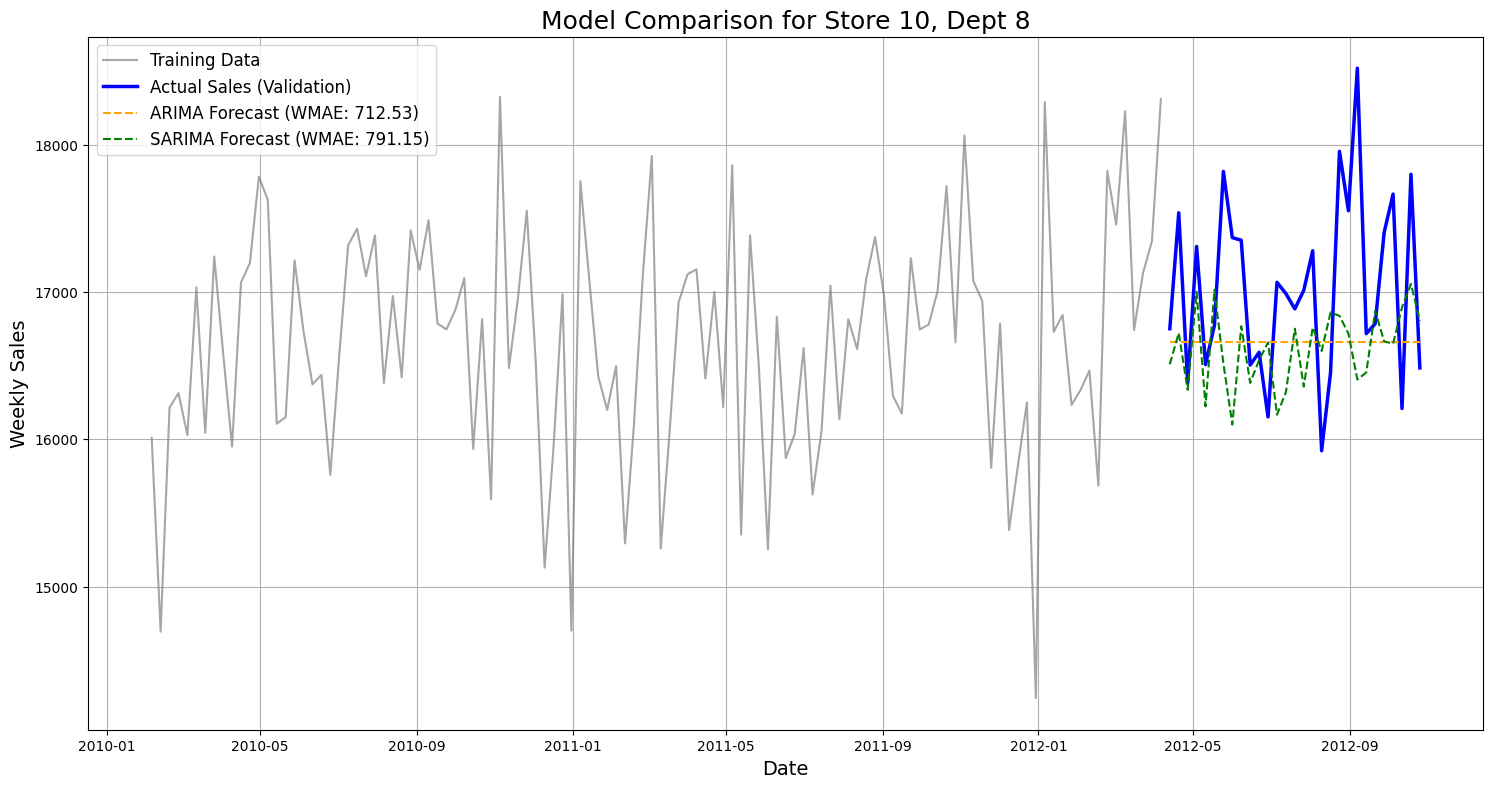

In [25]:
import matplotlib.pyplot as plt

print("\n--- Generating Forecast Comparison Plot ---")
plt.figure(figsize=(18, 9))
plt.plot(y_train.index, y_train, label='Training Data', color='gray', alpha=0.7)
plt.plot(y_val.index, y_val, label='Actual Sales (Validation)', color='blue', linewidth=2.5)

colors = ['orange', 'green', 'red']
for i, (model_name, forecast) in enumerate(all_forecasts.items()):
    wmae_score = all_metrics[model_name]['WMAE']
    plt.plot(forecast.index, forecast, label=f'{model_name} Forecast (WMAE: {wmae_score:.2f})', color=colors[i], linestyle='--')

plt.title(f'Model Comparison for Store {STORE_ID}, Dept {DEPT_ID}', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
